### **Imports**

In [45]:
from utils import visualise_gridsearch, fetch_top_predictions, make_top_3

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [46]:
from sklearn.metrics import precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

### **Data setup**

In [47]:
df = pd.read_csv('data/OnlineNewsPopularity.csv')
df = df.rename(columns=lambda x: x.strip())
y_raw = df['shares']

POPULARITY_SPLIT = 0.9

high_thresh = y_raw.quantile(POPULARITY_SPLIT)
y_class = (y_raw >= high_thresh).astype(int)

print("Class distribution:")
print(y_class.value_counts())

df_sorted = df.copy().sort_values('timedelta', ascending=False)

TRAIN_SPLIT = 0.85
train_size = int(len(df_sorted) * TRAIN_SPLIT)

train_df = df_sorted.iloc[:train_size]
test_df = df_sorted.iloc[train_size:]

X_train = train_df.drop(columns=['url', 'timedelta', 'shares'])
y_train_class = (train_df['shares'] >= high_thresh).astype(int)
y_train_reg_log = np.log1p(train_df['shares'])

X_test_full = test_df.drop(columns=['url', 'timedelta', 'shares'])
y_test_full_class = (test_df['shares'] >= high_thresh).astype(int)
y_test_full_reg_log = np.log1p(test_df['shares'])

test_splits = np.array_split(test_df, 100)

X_test_sets = []
y_test_sets_class = []
y_test_sets_reg_log = []

for ts in test_splits:
    X_test_sets.append(ts.drop(columns=['url', 'timedelta', 'shares']))
    y_test_sets_class.append((ts['shares'] >= high_thresh).astype(int))
    y_test_sets_reg_log.append(np.log1p(ts['shares']))

Class distribution:
shares
0    35615
1     4029
Name: count, dtype: int64


In [48]:
''' 2 available splitting types, TimeSeries overall gets better results '''

# cv = KFold(n_splits=3, shuffle=True, random_state=42)
cv = TimeSeriesSplit(n_splits=3)

In [49]:
cv_collector = {'xgb': {'baseline': 0, 'undersampling': 0, 'smote': 0, 'regression': 0},
                'rf': {'baseline': 0, 'undersampling': 0, 'smote': 0, 'regression': 0},
                'cat': {'baseline': 0, 'undersampling': 0, 'smote': 0, 'regression': 0}}

score_collector = {'xgb': {'baseline': 0, 'undersampling': 0, 'smote': 0, 'regression': 0},
                'rf': {'baseline': 0, 'undersampling': 0, 'smote': 0, 'regression': 0},
                'cat': {'baseline': 0, 'undersampling': 0, 'smote': 0, 'regression': 0}}

### **Scoring functions** 

The scoring function takes checks 90th percentile of the prediction probabilities of the positive class. It assumes that the most confident predictions are positive and calculates the accuracy on these items. 

If the model does not provide probabilities, the function returns the precision of positive class. 

In [50]:
def top10pct_scorer(estimator, X, y):
    # Case 1: estimator provides predict_proba
    if hasattr(estimator, "predict_proba"):
        proba = estimator.predict_proba(X)[:, 1]
        threshold = np.percentile(proba, 90)
        y_pred = (proba >= threshold).astype(int)
        return accuracy_score(y, y_pred)
    
    # Case 2: no probability output -> return precision score
    else:
        y_pred = estimator.predict(X)
        return precision_score(y, y_pred, zero_division=0)


In [51]:
def topk_scorer(estimator, X, y_true):
    proba = estimator.predict_proba(X)[:, 1]

    true_k = int(y_true.sum())

    top_idx = np.argsort(proba)[-true_k:]

    y_pred = np.zeros_like(y_true)
    y_pred[top_idx] = 1

    return precision_score(y_true, y_pred, zero_division=0)


In [52]:
def topk_regression_scorer(estimator, X, y_true, top_pct=0.1):
    y_pred = estimator.predict(X)
    k = int(len(y_true) * top_pct)

    top_pred_idx = np.argsort(y_pred)[-k:]
    top_true_idx = np.argsort(y_true)[-k:]

    y_pred_binary = np.zeros_like(y_true, dtype=int)
    y_true_binary = np.zeros_like(y_true, dtype=int)

    y_pred_binary[top_pred_idx] = 1
    y_true_binary[top_true_idx] = 1

    return precision_score(y_true_binary, y_pred_binary)

Although minor, I have a few doubts about top10pct_scorer. <br>
First, it assumes that your split will have a perfect 10% of extreme values. By Law of Large Numbers that is very likely, but even 9.9% will influence the scoring. <br>
Second, I think returning accuracy is a bit useless since you get a number around 0.85 - 0.9 and have no idea what it means. If you return precision like in topk_scorer, it will directly reflect the scores we get at the end (around 0.2 - 0.3).

### **XGBoost baseline** 

In [53]:
standard_pipeline = SkPipeline([
    ("xgb", XGBClassifier(
        random_state=42,
    ))
])

standard_param_grid = {
    "xgb__n_estimators": [50, 100, 150],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__max_depth": [5, 7, 9],
}

standard_grid = GridSearchCV(
    estimator=standard_pipeline,
    param_grid=standard_param_grid,
    scoring=topk_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("\n=== Running GridSearchCV ===")
standard_grid.fit(X_train, y_train_class)
print("\nBest parameters:", standard_grid.best_params_)
print("Best CV score:", round(standard_grid.best_score_, 3))
cv_collector['xgb']['baseline'] = round(standard_grid.best_score_, 4)


=== Running GridSearchCV ===
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best parameters: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}
Best CV score: 0.262


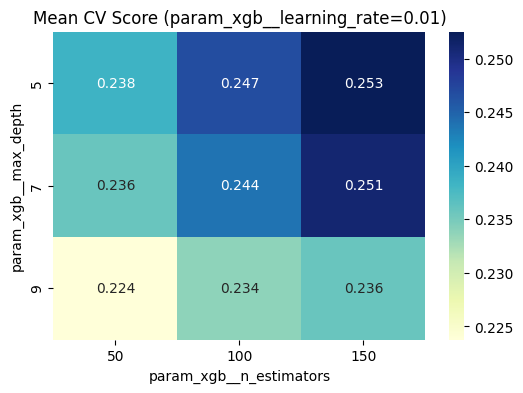

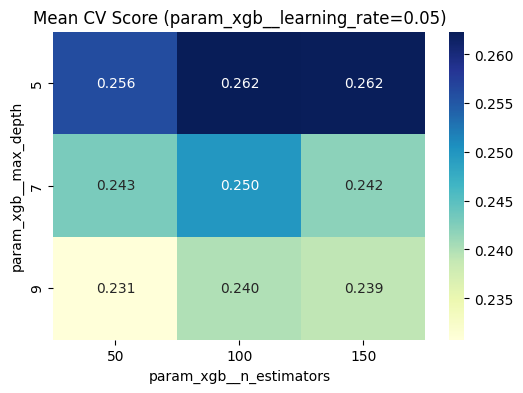

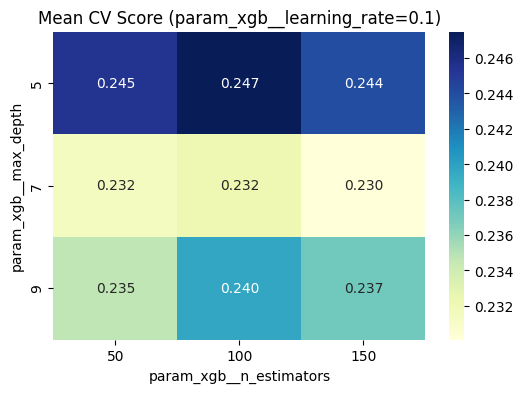

In [54]:
# cv_results_df = pd.DataFrame(standard_grid.cv_results_)
# print(cv_results_df.columns)

visualise_gridsearch(pd.DataFrame(standard_grid.cv_results_), 
                     'param_xgb__max_depth', 'param_xgb__n_estimators', 'param_xgb__learning_rate')

In [55]:
best_model = standard_grid.best_estimator_

top10_list = make_top_3(best_model, X_test_sets, y_test_sets_class)
hit_list = fetch_top_predictions(top10_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)

print(np.average(hit_list))
score_collector['xgb']['baseline'] = round(np.average(hit_list), 4)

0.84


### **XGBoost with undersampling**

In [56]:
undersampling_pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('xgb', XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])

undersampling_param_grid = {
    "xgb__n_estimators": [100, 300, 500],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__max_depth": [1, 3, 5],
}

undersampling_grid = GridSearchCV(
    estimator=undersampling_pipeline,
    param_grid=undersampling_param_grid,
    scoring=topk_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)


print("\n=== Running GridSearchCV ===")
undersampling_grid.fit(X_train, y_train_class)
print("\nBest parameters:", undersampling_grid.best_params_)
print("Best CV score:", round(undersampling_grid.best_score_, 3))
cv_collector['xgb']['undersampling'] = round(undersampling_grid.best_score_, 4)


=== Running GridSearchCV ===
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 1, 'xgb__n_estimators': 300}
Best CV score: 0.255


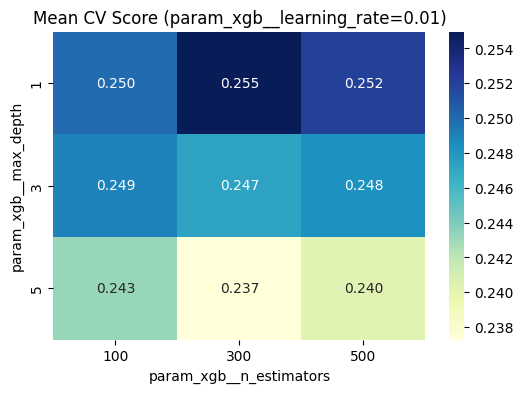

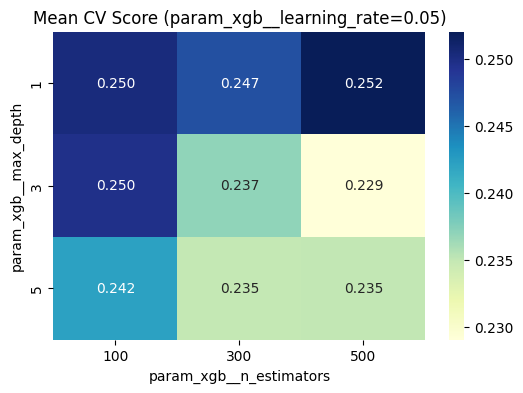

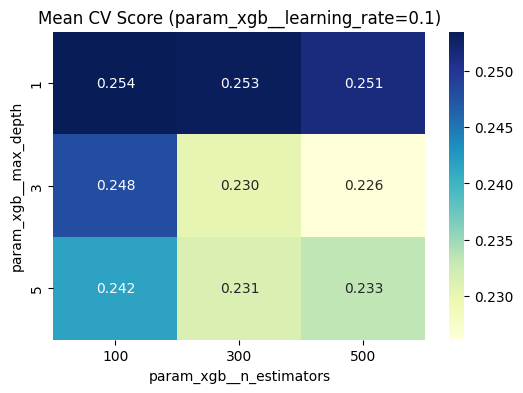

In [57]:
visualise_gridsearch(pd.DataFrame(undersampling_grid.cv_results_),
                     'param_xgb__max_depth', 'param_xgb__n_estimators', 'param_xgb__learning_rate')

In [58]:
best_model = undersampling_grid.best_estimator_

top10_list = make_top_3(best_model, X_test_sets, y_test_sets_class)
hit_list = fetch_top_predictions(top10_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)

np.average(hit_list)
score_collector['xgb']['undersampling'] = round(np.average(hit_list), 4)

### **XGBoost with undersampling and SMOTE**

In [59]:
smote_pipeline = ImbPipeline([
    ("resample", SMOTETomek(random_state=42)),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])

smote_param_grid = {
    "xgb__n_estimators": [100, 300, 500],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__max_depth": [1, 3, 5, 7],
}

smote_grid = GridSearchCV(
    estimator=smote_pipeline,
    param_grid=smote_param_grid,
    scoring=topk_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("\n=== Running GridSearchCV ===")
smote_grid.fit(X_train, y_train_class)
print("\nBest parameters:", smote_grid.best_params_)
print("Best CV score:", round(smote_grid.best_score_, 3))
cv_collector['xgb']['smote'] = round(smote_grid.best_score_, 4)


=== Running GridSearchCV ===
Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

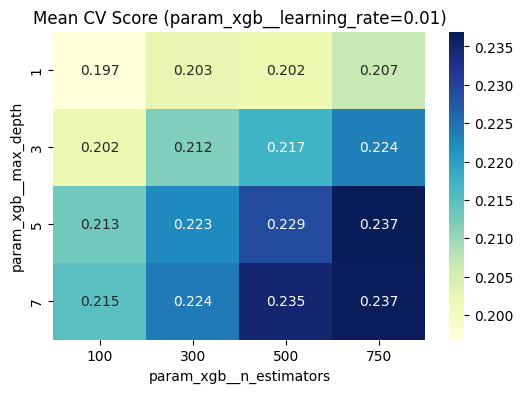

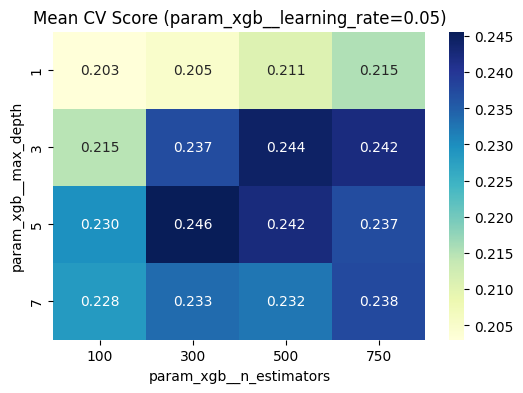

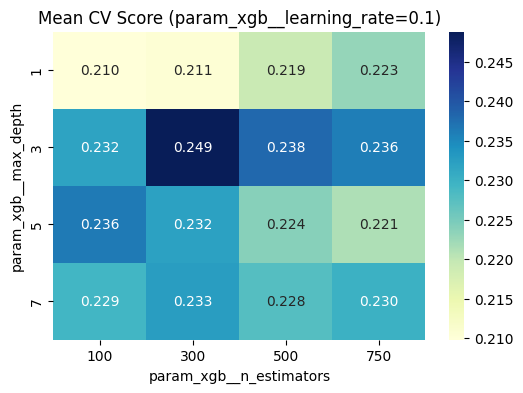

In [ ]:
visualise_gridsearch(pd.DataFrame(smote_grid.cv_results_),
                     'param_xgb__max_depth', 'param_xgb__n_estimators', 'param_xgb__learning_rate')

In [ ]:
best_model = smote_grid.best_estimator_

top10_list = make_top_3(best_model, X_test_sets, y_test_sets_class)
hit_list = fetch_top_predictions(top10_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)

np.average(hit_list)
score_collector['xgb']['smote'] = round(np.average(hit_list), 4)

np.float64(0.79)

### **XGBoost regression**

In [ ]:
reg_pipeline = SkPipeline([
    ("xgb", XGBRegressor(
        random_state=42,
    ))
])

reg_param_grid = {
    "xgb__n_estimators": [50, 100, 300, 500],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__max_depth": [1, 3, 5, 7],
}

reg_grid = GridSearchCV(
    estimator=reg_pipeline,
    param_grid=reg_param_grid,
    scoring=topk_regression_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("\n=== Running GridSearchCV for XGBRegressor ===")
reg_grid.fit(X_train, y_train_reg_log)
print("\nBest parameters:", reg_grid.best_params_)
print("Best CV score:", round(reg_grid.best_score_, 3))
cv_collector['xgb']['regression'] = round(reg_grid.best_score_, 4)


=== Running GridSearchCV for XGBRegressor ===
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 7, 'xgb__n_estimators': 300}
Best CV score: 0.243


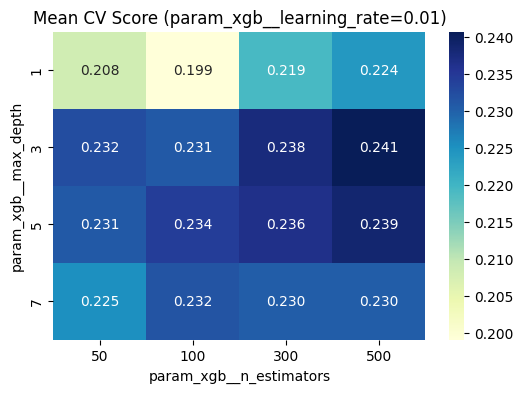

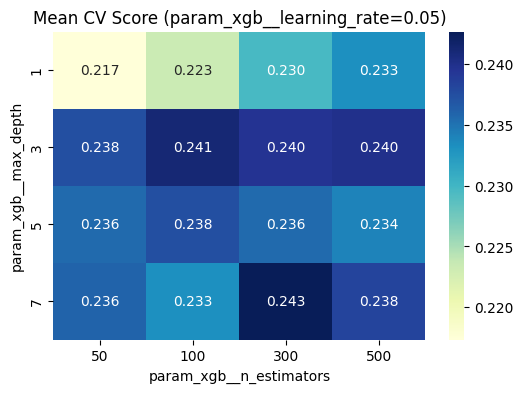

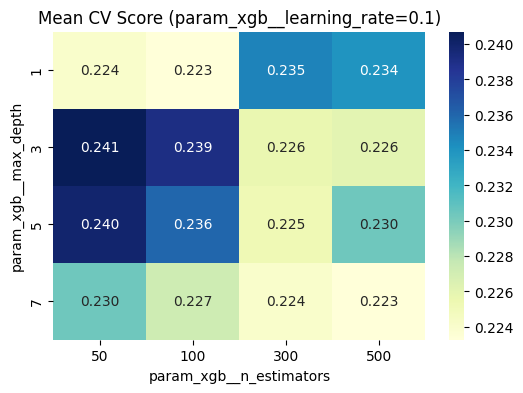

In [ ]:
# cv_results_df = pd.DataFrame(standard_grid.cv_results_)
# print(cv_results_df.columns)

visualise_gridsearch(pd.DataFrame(reg_grid.cv_results_), 
                     'param_xgb__max_depth', 'param_xgb__n_estimators', 'param_xgb__learning_rate')

In [ ]:
best_model = reg_grid.best_estimator_

top10_list = make_top_3(best_model, X_test_sets, y_test_sets_class, regression=True)
hit_list = fetch_top_predictions(top10_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)

np.average(hit_list)
score_collector['xgb']['regression'] = round(np.average(hit_list), 4)

np.float64(0.7)

### **Random Forest baseline**


In [ ]:

randomForest_pipeline = ImbPipeline(steps=[
    ('clf', RandomForestClassifier(200,random_state=42))
])


randomForest_param_grid = {
    'clf__max_depth': [3, 10, 15, 25],
    'clf__min_samples_split': [3, 5, 10, 20],
    'clf__max_features': ['sqrt']
}

randomForest_grid = GridSearchCV(
    estimator=randomForest_pipeline,
    param_grid=randomForest_param_grid,
    scoring=topk_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)


print("\n=== Running GridSearchCV ===")
randomForest_grid.fit(X_train, y_train_class)
print("\nBest parameters:", randomForest_grid.best_params_)
print("Best CV score:", round(randomForest_grid.best_score_, 3))
cv_collector['rf']['baseline'] = round(randomForest_grid.best_score_, 4)


=== Running GridSearchCV ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits


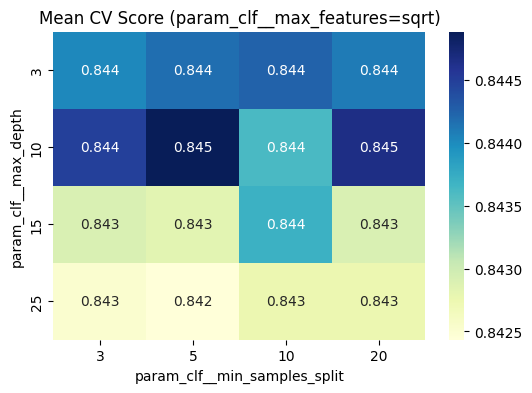

In [ ]:
# cv_results_df = pd.DataFrame(standard_grid.cv_results_)
# print(cv_results_df.columns)

visualise_gridsearch(pd.DataFrame(randomForest_grid.cv_results_), 
                     'param_clf__max_depth', 'param_clf__min_samples_split', 'param_clf__max_features')

In [ ]:
best_model = randomForest_grid.best_estimator_

top3_list = make_top_3(best_model, X_test_sets, y_test_sets_class)
hit_list = fetch_top_predictions(top3_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)

np.average(hit_list)
score_collector['rf']['baseline'] = round(np.average(hit_list), 4)

np.float64(0.73)

### **Random Forest with undersampling**


In [ ]:

randomForest_underSample_pipeline = ImbPipeline(steps=[
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf', RandomForestClassifier(200,random_state=42))
])


randomForest_underSample_param_grid = {
    'clf__max_depth': [3, 10, 15, 25],
    'clf__min_samples_split': [3, 5, 10, 20],
    'clf__max_features': ['sqrt']
}

randomForest_underSample_grid = GridSearchCV(
    estimator=randomForest_underSample_pipeline,
    param_grid=randomForest_underSample_param_grid,
    scoring=topk_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)


print("\n=== Running GridSearchCV ===")
randomForest_underSample_grid.fit(X_train, y_train_class)
print("\nBest parameters:", randomForest_underSample_grid.best_params_)
print("Best CV score:", round(randomForest_underSample_grid.best_score_, 3))
cv_collector['rf']['undersampling'] = round(randomForest_underSample_grid.best_score_, 4)


=== Running GridSearchCV ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters: {'clf__max_depth': 3, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 3}
Best CV score: 0.844


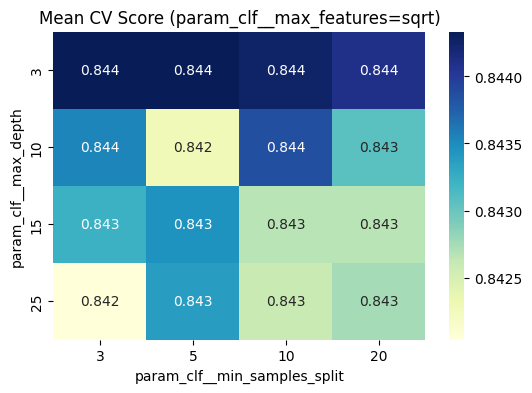

In [ ]:
# cv_results_df = pd.DataFrame(standard_grid.cv_results_)
# print(cv_results_df.columns)

visualise_gridsearch(pd.DataFrame(randomForest_underSample_grid.cv_results_), 
                     'param_clf__max_depth', 'param_clf__min_samples_split', 'param_clf__max_features')

In [ ]:
best_model = randomForest_underSample_grid.best_estimator_

top3_list = make_top_3(best_model, X_test_sets, y_test_sets_class)
hit_list = fetch_top_predictions(top3_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)

np.average(hit_list)
score_collector['rf']['undersampling'] = round(np.average(hit_list), 4)

np.float64(0.78)

### **Random Forest with undersampling and SMOTE**


In [ ]:

randomForest_smote_pipeline = ImbPipeline(steps=[
    ("resample", SMOTETomek(sampling_strategy=0.3, random_state=42)),
    ('clf', RandomForestClassifier(200,random_state=42))
])


randomForest_smote_param_grid = {
    'clf__max_depth': [3, 10, 15, 25],
    'clf__min_samples_split': [3, 5, 10, 20],
    'clf__max_features': ['sqrt']
}

randomForest_smote_grid = GridSearchCV(
    estimator=randomForest_smote_pipeline,
    param_grid=randomForest_smote_param_grid,
    scoring=topk_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)


print("\n=== Running GridSearchCV ===")
randomForest_smote_grid.fit(X_train, y_train_class)
print("\nBest parameters:", randomForest_smote_grid.best_params_)
print("Best CV score:", round(randomForest_smote_grid.best_score_, 3))
cv_collector['rf']['smote'] = round(randomForest_smote_grid.best_score_, 4)


=== Running GridSearchCV ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 

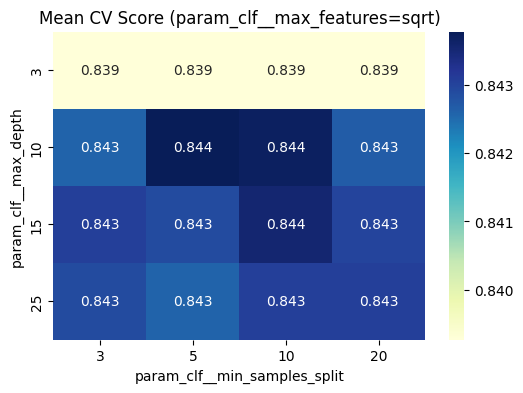

In [ ]:
# cv_results_df = pd.DataFrame(standard_grid.cv_results_)
# print(cv_results_df.columns)

visualise_gridsearch(pd.DataFrame(randomForest_smote_grid.cv_results_), 
                     'param_clf__max_depth', 'param_clf__min_samples_split', 'param_clf__max_features')

In [ ]:
best_model = randomForest_smote_grid.best_estimator_

top3_list = make_top_3(best_model, X_test_sets, y_test_sets_class)
hit_list = fetch_top_predictions(top3_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)

np.average(hit_list)
score_collector['rf']['smote'] = round(np.average(hit_list), 4)

np.float64(0.68)

### **Random Forest regression**

In [ ]:
randomForest_regressor_pipeline = ImbPipeline(steps=[
    ('clf', RandomForestRegressor(200,random_state=42))
])


randomForest_regressor_param_grid = {
    'clf__max_depth': [3, 10, 15, 25],
    'clf__min_samples_split': [3, 5, 10, 20],
    'clf__max_features': ['sqrt']
}

randomForest_regressor_grid = GridSearchCV(
    estimator=randomForest_regressor_pipeline,
    param_grid=randomForest_regressor_param_grid,
    scoring=topk_regression_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)


print("\n=== Running GridSearchCV ===")
randomForest_regressor_grid.fit(X_train, y_train_class)
print("\nBest parameters:", randomForest_regressor_grid.best_params_)
print("Best CV score:", round(randomForest_regressor_grid.best_score_, 3))
cv_collector['rf']['regression'] = round(randomForest_regressor_grid.best_score_, 4)


=== Running GridSearchCV ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters: {'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 3}
Best CV score: 0.241


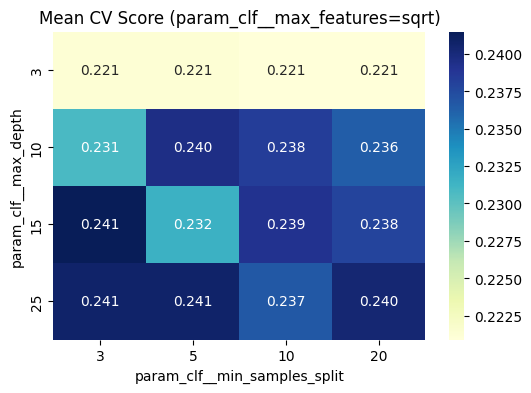

In [ ]:
# cv_results_df = pd.DataFrame(standard_grid.cv_results_)
# print(cv_results_df.columns)

visualise_gridsearch(pd.DataFrame(randomForest_regressor_grid.cv_results_), 
                     'param_clf__max_depth', 'param_clf__min_samples_split', 'param_clf__max_features')

In [ ]:
best_model = randomForest_regressor_grid.best_estimator_

top3_list = make_top_3(best_model, X_test_sets, y_test_sets_class, regression=True)
hit_list = fetch_top_predictions(top3_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)

np.average(hit_list)
score_collector['rf']['regression'] = round(np.average(hit_list), 4)

np.float64(0.64)

### **Model comparison**

In [ ]:
# cv_collector['rf']['baseline'] = np.float64(0.25)
# cv_collector['rf']['undersampling'] = np.float64(0.3)
# cv_collector['rf']['smote'] = np.float64(0.27)
# cv_collector['rf']['regression'] = np.float64(0.26)
# cv_collector['cat']['baseline'] = np.float64(0.2)
# cv_collector['cat']['undersampling'] = np.float64(0.31)
# cv_collector['cat']['smote'] = np.float64(0.22)
# cv_collector['cat']['regression'] = np.float64(0.21)

cv_collector

{'xgb': {'baseline': np.float64(0.25),
  'undersampling': np.float64(0.255),
  'smote': np.float64(0.249),
  'regression': np.float64(0.243)},
 'rf': {'baseline': np.float64(0.25),
  'undersampling': np.float64(0.3),
  'smote': np.float64(0.27),
  'regression': np.float64(0.26)},
 'cat': {'baseline': np.float64(0.2),
  'undersampling': np.float64(0.31),
  'smote': np.float64(0.22),
  'regression': np.float64(0.21)}}

In [ ]:
score_collector

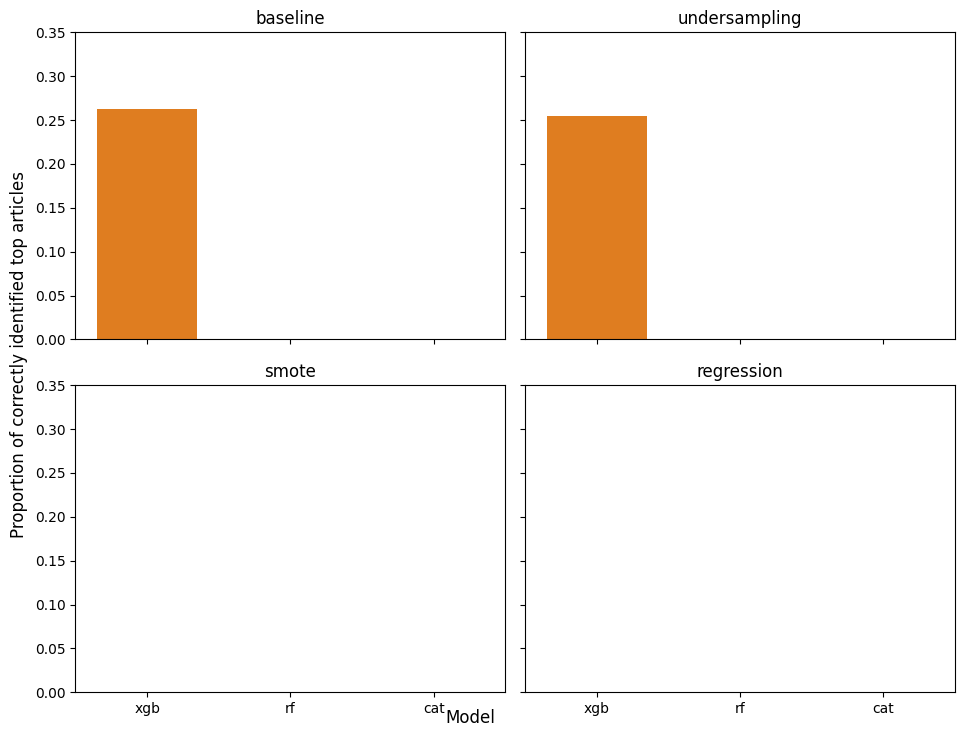

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(cv_collector).T.reset_index().melt(
    id_vars='index', var_name='Strategy', value_name='Score')
df.rename(columns={'index': 'Model'}, inplace=True)

strategies = df['Strategy'].unique()
models = df['Model'].unique()
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

bright_palette = sns.color_palette('bright')
blue = bright_palette[0]
orange = bright_palette[1]

for i, strategy in enumerate(strategies):
    ax = axes[i]
    subset = df[df['Strategy'] == strategy]
    
    colors = [orange if score == subset['Score'].max() else blue for score in subset['Score']]
    
    sns.barplot(x='Model', y='Score', data=subset, ax=ax, palette=colors, width=0.7)
    ax.set_title(strategy)
    ax.set_ylim(0, 0.35)
    
    ax.set_ylabel('')
    ax.set_xlabel('')

fig.text(0.04, 0.5, 'Proportion of correctly identified top articles', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.04, 'Model', ha='center', rotation='horizontal', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()